## Designing Nonlinear Neural Network Models for Fitting Nonlinear Data

Many systems we want to model are nonlinear: small changes in input do not always produce proportional changes in output. Effects can saturate, switch on or off, or behave differently in different regions of the input space. Linear models are attractive because they are simple and interpretable, but this simplicity is also their main limitation - no matter how many linear transformations we stack, the result is still a linear function.

To represent nonlinear behavior, we need model components that can bend, clip, or reshape signals as they pass through a system.  In this notebook, we explore how nonlinearity is introduced into neural network models and why it is essential for their expressive power. We begin by looking at what linear transformations can and cannot do, then introduce activation functions as simple nonlinear maps applied between layers. 

Through visualizations and small experiments, we examine how different activation functions transform their inputs and how these transformations affect learning and model behavior.




## Setup

### Import Libraries

In [3]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchinfo import summary
from torch import optim

### Utility Functions

In [4]:
def update_model(model, loss_function, optimizer, x, y_obs) -> float:
    """
    Do one training iteration, and return its loss.
    
    Arguments:
      - model: the PyTorch model we'll be training (e.g. `nn.Sequential(Linear(1, 1)))`)
      - loss_function: the loss function we'll use to estimate model fit, by calculating loss (e.g. `nn.MSELoss()`)
      - optimizer: a PyTorch "Optimizer" object that decides how much to update each parameter. (e.g. `optim.SGD()`)
      - x: The `x` input data used for training
      - y_obs: The expected result data used for training. (used here for "supervised" training.)    
    """

    # Forward Pass
    optimizer.zero_grad()                  # Reset parameter gradients
    y_pred = model(x)                      # Make a Prediction
    loss = loss_function(y_pred, y_obs)    # Calculate the overall prediction error ("Loss")

    # Backward Pass
    loss.backward()   # Calculate the loss gradients and store them in each parameters' ".grad" attribute
    optimizer.step()  # Update the model's parameters, based on their stored gradients

    # record the loss, for plotting or logging
    return loss.item()  


def plot_losses(losses, ax=None) -> None:
    """Plot the losses over each training iteration."""
    if ax is None:
        ax = plt.gca()
    ax.plot(losses, ':.')
    ax.set(
        title='Loss Over Learning Iterations',
        xlabel='Iteration #',
        ylabel='Loss',
    )
    

def plot_1d_model_fit(model, x, y_obs, ax=None) -> None:
    """Plot a scatterplot and regression line to show model fit"""
    if ax is None:
        ax = plt.gca()

    # Make a scatterplot of the data points (x vs y_obs)
    ax.plot(x, y_obs, '.', markersize=1.5);

    # Plot a regression line
    x_range = torch.linspace(x.min(), x.max(), 100)  # Get a sequence of x values
    y_pred = model(x_range.reshape(-1, 1))
    ax.plot(x_range, y_pred.detach().numpy(), ':', linewidth=2)
    ax.set(title='Model Fit', xlabel='X', ylabel='Y')


---

## Section 1: Creating Layered Pipeline Models with `nn.Module` and `nn.Sequential()`

This section introduces the idea of building models as pipelines of transformations. Using `nn.Module` and `nn.Sequential`, we combine simple operations into layered models that map inputs to outputs step by step.

We begin with hand-designed nonlinear transformations (such as squaring, cubing, or taking the sine) to see how they affect model behavior. This helps build intuition for how nonlinear structure can be added to a model—and also shows the limitations of relying on knowing the “right” transformation in advance.

| Code | Description |
| :-- | :-- |
| `x**3` | Raise `x` to the power of 3 (the cube of `x`). |
| `torch.sin(x)` | The sine of the tensor `x`. |
| `nn.Linear(n_features_in, n_features_out)` | Creates a linear model that takes in `n_features_in` input features (nodes) and<br>outputs `n_features_out` features (nodes).|
| `model = nn.Sequential(`<br>&nbsp;&nbsp;&nbsp;&nbsp;`Square(),`<br>&nbsp;&nbsp;&nbsp;&nbsp;`nn.Linear(1,1)`<br>`)` | Creates a model where multiple transformations are stacked in a sequential order. This ensures that input is passed through the model in that order during the forward pass. The input to this model is first passed through the class named `Square()`, then through the linear layer. |

### Exercises

**Example**: Update the `Square.forward()` method, so that it returns $ x^2 $ to better- fit the data. 

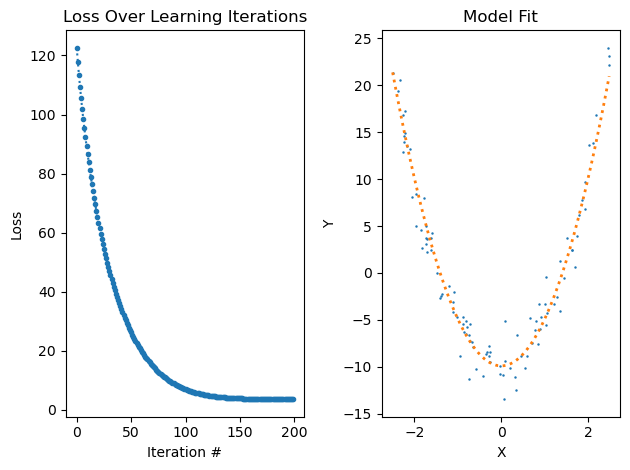

In [ ]:
# Generate Data
x = 5 * (torch.rand(100, 1) - .5)
y_obs = 5 * x ** 2 - 10 + 2 * torch.randn_like(x)

# Create Model
class Square(nn.Module):
    def forward(self, x):
        return x ** 2  # UPDATE ME!

model = nn.Sequential(Square(), nn.Linear(1, 1))  # UPDATE ME!

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

**Exercise**: As the plots show, this model doesn't fit the data very well.  Update the `ThirdPower.forward()` method, so that it returns $ x^3 $ to better fit the data, and add ThirdPower() to the neural network model.

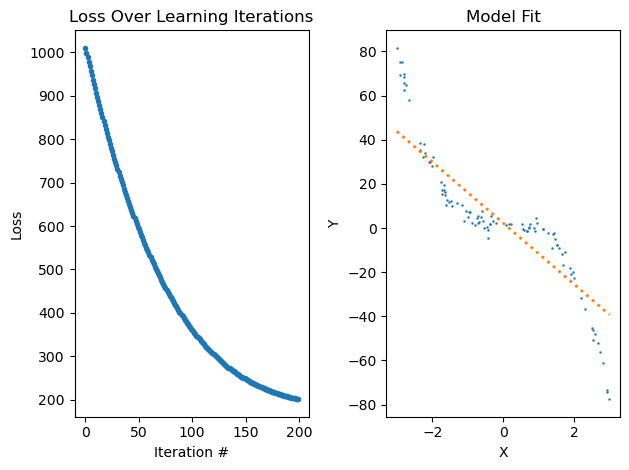

In [ ]:
# Generate Data
x = 6 * (torch.rand(100, 1) - .5)
y_obs = -3 * x ** 3 + 2 + 3 * torch.randn_like(x)

# Create Model
class ThirdPower(nn.Module):
    def forward(self, x):
        return x  # Update Me!

model = nn.Sequential(nn.Linear(1, 1))  # UPDATE ME! - Add ThirdPower()

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

**Exercise**: As the plots show, this model doesn't fit the data very well.  Update the `Sin.forward()` method, so that it returns $ \sin{x} $ to better- fit the data, and add it to the neural network model.  (hint: `torch.sin(x)`)

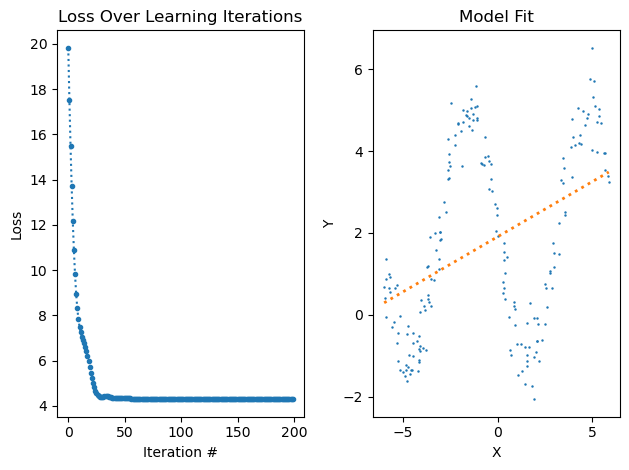

In [6]:
# Generate Data
x = 12 * (torch.rand(200, 1) - .5)
y_obs = -3 * torch.sin(x) + 2 + .5 * torch.randn_like(x)

# Create Model
class Sin(nn.Module):
    def forward(self, x):
        return x   # UPDATE ME!

model = nn.Sequential(nn.Linear(1, 1))  # UPDATE ME! - add Sin()

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

---

## Section 2: Using Activation Functions to Build Generalizable Neural Networks

In practice, we usually do not know the exact nonlinear transformation needed to fit a dataset. Instead of hard-coding specific functions, neural networks use activation functions to introduce nonlinearity in a flexible and learnable way.


Activation functions introduce nonlinearity into a model by transforming its outputs. They are applied to the output of a layer so that the model can represent more complex relationships than simple linear combinations.



```mermaid
flowchart LR
    X[Input x]

    L1["Linear layer\n(Wx + b)"]
    L2["Linear layer\n(Wx + b)"]

    A1["Activation\n(ReLU / GELU / Tanh)"]

    Y1["Output\n(still linear)"]
    Y2["Output\n(nonlinear)"]

    X --> L1 --> L2 --> Y1
    X --> L1 --> A1 --> L2 --> Y2


```

In this section, we build models with hidden layers and activation functions, focusing on how even simple nonlinearities—when combined with enough units—allow a model to fit a wide range of nonlinear patterns. The goal is not to find a perfect architecture, but to see how expressive power emerges from layering linear transformations and activations.



### Exercises


These exercises are funny--every single one has the same solution!  We'll make the same change to each model, adding a large hidden layer with a simple `ReLU()` activation function in the middle, looking to see how it enables a wide variety of data to be fit.  

The Code to Use: `model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))`

**Example**: Add a `ReLU()` activation function and a hidden layer to the model, to fit this nonlinear data.  How many nodes are in the hidden layer are needed to get a good fit?

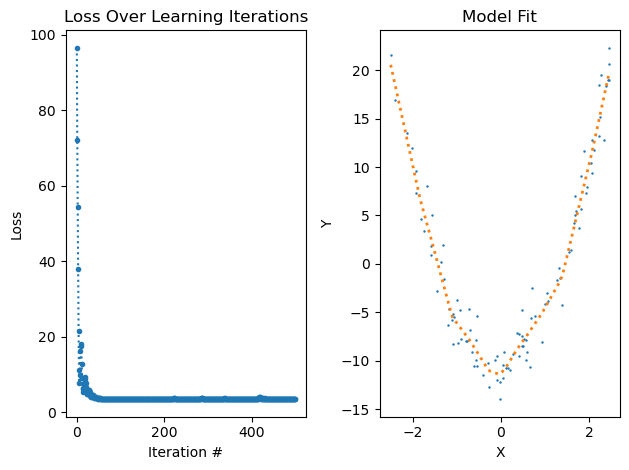

In [7]:
# Generate Data
x = 5 * (torch.rand(100, 1) - .5)
y_obs = 5 * x ** 2 - 10 + 2 * torch.randn_like(x)


model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))  # Update Me!

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 500
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

**Exercise**: Add a `ReLU()` activation function and a hidden layer to the model, to fit this nonlinear data.  How many nodes are in the hidden layer are needed to get a good fit?

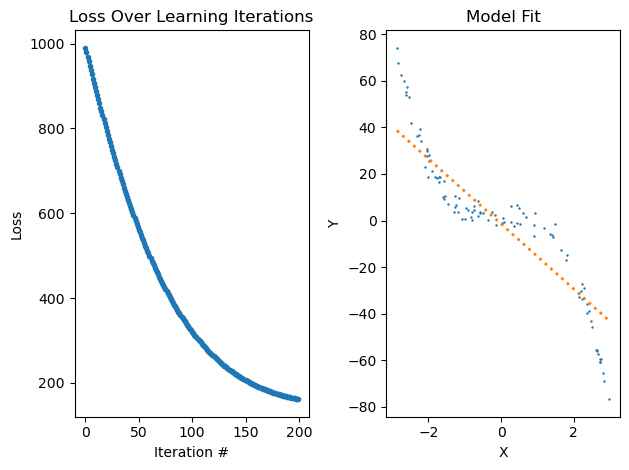

In [13]:
# Generate Data
x = 6 * (torch.rand(100, 1) - .5)
y_obs = -3 * x ** 3 + 2 + 3 * torch.randn_like(x)


model = nn.Sequential(nn.Linear(1, 1))  # UPDATE ME!


# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

**Exercise**: Once again, please add a `ReLU()` activation function and a hidden layer to the model, to fit this nonlinear data.  How many nodes are needed in the hidden layer to get a good fit?

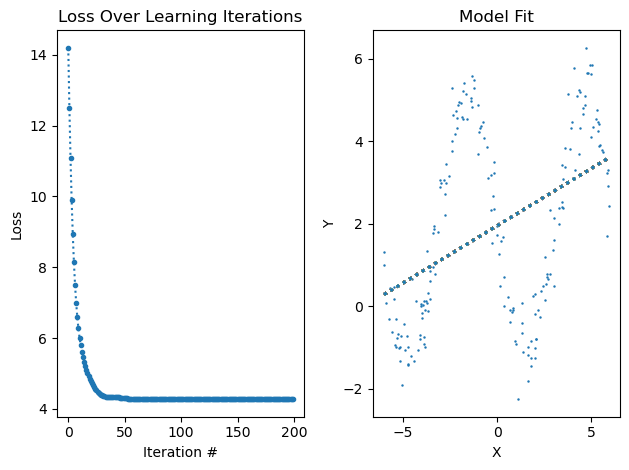

In [17]:
# Generate Data
x = 12 * (torch.rand(200, 1) - .5)
y_obs = -3 * torch.sin(x) + 2 + .5 * torch.randn_like(x)

# Create Model
class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

model = nn.Sequential(nn.Linear(1, 100))  # UPDATE ME!

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

---

## Section 3: Comparing Activation Functions

So, what exactly are these activations functions?  In this section, we'll take a look at several common ones, getting to know their shapes and their uses.  

At first glance, these activation functions can feel like arbitrary mathematical choices. In practice, however, they play a very specific role: they introduce nonlinearity while still allowing gradients to flow during training. The choice of activation function influences how easily a network can learn, how stable training is, and what kinds of patterns the model can represent:


| Code | Description |
| :-- | :-- |
| **`nn.ReLU()`** | Applies `max(0, x)`, setting all negative inputs to zero while leaving positive values unchanged. It is simple, fast, and helps avoid vanishing gradients, but it is not smooth and can produce “dead” neurons. |  
| **`nn.LeakyReLU()`** | A small modification of ReLU that allows negative inputs to pass through with a small slope instead of zero. This reduces the risk of dead neurons while keeping most of ReLU’s simplicity and performance benefits. |
| **`nn.GELU()`** | Smoothly suppresses negative values while keeping positive values mostly linear, weighting inputs by their probability under a Gaussian. It provides stable gradients and is the default activation in Transformer models, at a higher computational cost than ReLU. |
| **`nn.SiLU()`** | Also known as *Swish*, it multiplies the input by its sigmoid, creating a smooth transition from near-zero for negative inputs to linear behavior for positive ones. It often performs similarly to GELU and is a popular modern alternative. |
| **`nn.Tanh()`** | Squashes inputs into the range `[-1, 1]`, producing zero-centered outputs. It is smooth but saturates for large inputs, which can lead to vanishing gradients in deep networks. |
| **`nn.Sigmoid()`** | Squashes inputs into the range `[0, 1]`, making it useful for modeling probabilities. It saturates strongly and is rarely used in hidden layers of modern deep networks. |
| **`nn.Softmax()`** | Converts a vector of inputs into a probability distribution whose values sum to 1. It is typically used in the output layer for multi-class classification, **not in hidden layers.** |





Please run the cell below, to get the plotting functions for this section's exercises:

In [6]:
def plot_data_and_derivative(x, y) -> None:

    # Estimate Derivative
    dy_dx = y.diff() / x.diff()  

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, constrained_layout=True)

    ax1.plot(x, y, ); 
    ax1.set(title='Function', xlabel='x', ylabel='y',)
    ax1.grid()

    ax2.plot(x[1:], dy_dx, '.:'); 
    ax2.set(title='Derivative of Function', xlabel='x', ylabel='dy / dx');


### Exercises

Let's look at what some of the most common common activation functions do to their input!  For each exercise, please replace the `activation_function` variable with the activation function that has the requested attributes.

**Example**: Which Activation Function is bounded between -1 and 1?

Text(0.5, 0.98, 'Tanh')

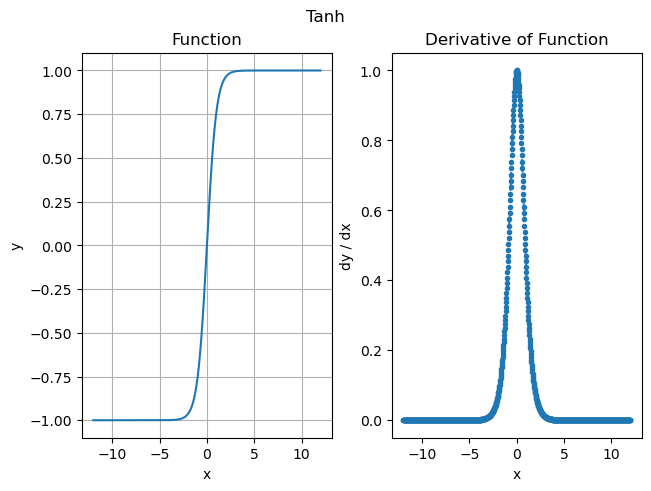

In [ ]:
activation_function = nn.Tanh();  # UPDATE ME! either ReLU, LeakyReLU, GELU, SiLU, Tanh, Sigmoid, or Softmax

# Plot Activation Function
x = torch.linspace(-12, 12, 1001)
y = activation_function(x)
plot_data_and_derivative(x, y)
plt.suptitle(activation_function.__class__.__name__)

# Answer: The output of Tanh is bounded between -1 and 1

**Exercise**: Which Activation Function is exactly zero for all negative numbers, is increasing in a straight line for all positive numbers, and has a fixed derivative that jumps to 1 at x=0?

Text(0.5, 0.98, 'Identity')

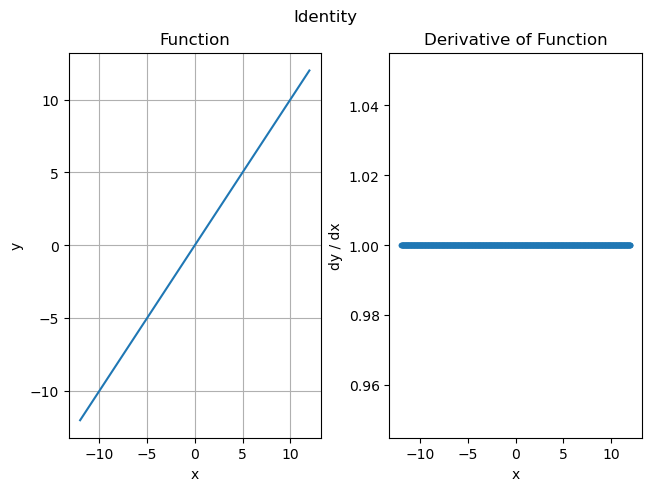

In [329]:
activation_function = nn.Identity();  # UPDATE ME! either ReLU, LeakyReLU, GELU, SiLU, Tanh, Sigmoid, or Softmax

# Plot Activation Function
x = torch.linspace(-12,12,1001)
y = activation_function(x)
plot_data_and_derivative(x, y)
plt.suptitle(activation_function.__class__.__name__)

**Exercise**: Which Activation Function is bounded between 0 and 1? (Note: it makes this function great for expressing outputs as probabilities)

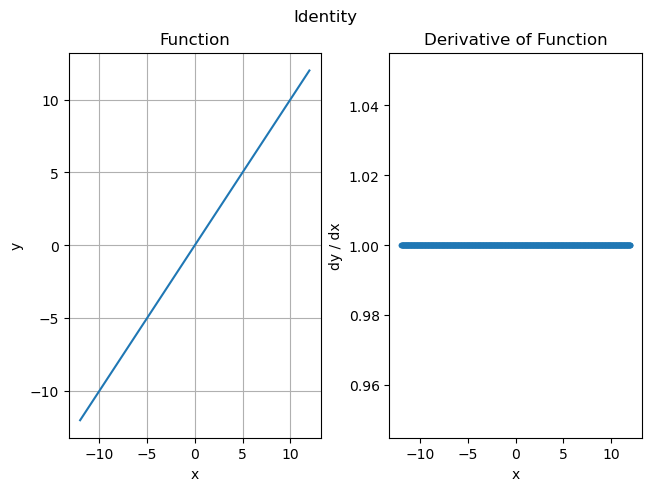

In [7]:
activation_function = nn.Identity();  # UPDATE ME! either ReLU, LeakyReLU, GELU, SiLU, Tanh, Sigmoid, or Softmax

# Plot Activation Function
x = torch.linspace(-12, 12, 1001)
y = activation_function(x)
plot_data_and_derivative(x, y)
plt.suptitle(activation_function.__class__.__name__);


**Exercise**: Having sharp derivatives is not great for machine learning.  Which Activation Function has a shape roughly like ReLU (fixed positive derivative for all positive values of `x`), but doesn't have a sharp change in the derivative?

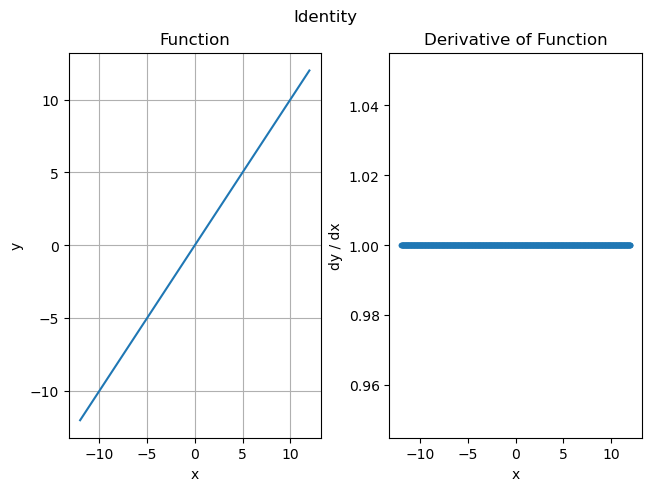

In [324]:
activation_function =  nn.Identity();  # UPDATE ME! either ReLU, LeakyReLU, GELU, SiLU, Tanh, Sigmoid, or Softmax

# Plot Activation Function
x = torch.linspace(-12,12,1001)
y = activation_function(x)
plot_data_and_derivative(x, y)
plt.suptitle(activation_function.__class__.__name__);

**Exercise**: Now we have two inputs.  Which activation function ensures that the sum of all the outputs add up to 1 (look at the rightmost plot)? 

**Note**: this makes this activation function great for expressing multi-class values as proportions.

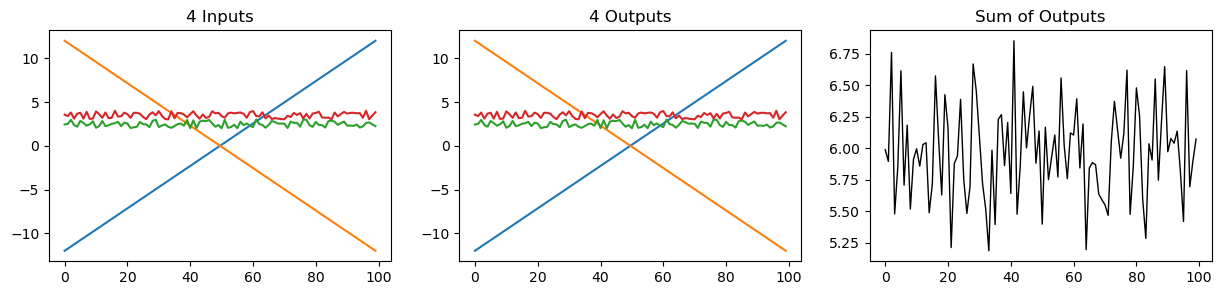

In [19]:
activation_function = nn.Identity();  # UPDATE ME! either ReLU, LeakyReLU, GELU, SiLU, Tanh, Sigmoid, or Softmax

# Plot Activation Function for four inputs and its Sum over its four outputs
x = torch.cat([
        torch.linspace(-12,12,100).reshape(-1, 1), 
        torch.linspace(12,-12,100).reshape(-1, 1), 
        torch.rand(100).reshape(-1, 1) + 2, 
        torch.rand(100).reshape(-1, 1) + 3, 
    ], 
    dim=-1
)
y = activation_function(x)
y_sum = y.sum(axis=1)

plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1); plt.plot(x); plt.title('4 Inputs')
plt.subplot(1, 3, 2); plt.plot(y); plt.title('4 Outputs')
plt.subplot(1, 3, 3); plt.plot(y_sum, 'k', linewidth=1); plt.title('Sum of Outputs'); (plt.ylim(-2, 2) if y_sum.max().item() < 2 else None);

---

## Section 4: Extending `nn.Module` to Create Customized, Multi-Feature, Trainable Neural Network Layers

Below are demonstrations of how `nn.Module` can be used to do things beyond the simple 1D, parameter-less transformations we've done above.  This system makes PyTorch quite extendable!

#### Demo: Multiple Features

One feature in, more features out!  Concatenating multiple transformation into their own columns makes it simpler to generate more features to fit.  In the cell below, both `sin()` and `cos()` are calculated in order to make it simple to fit oscillating signals with imaginary terms.

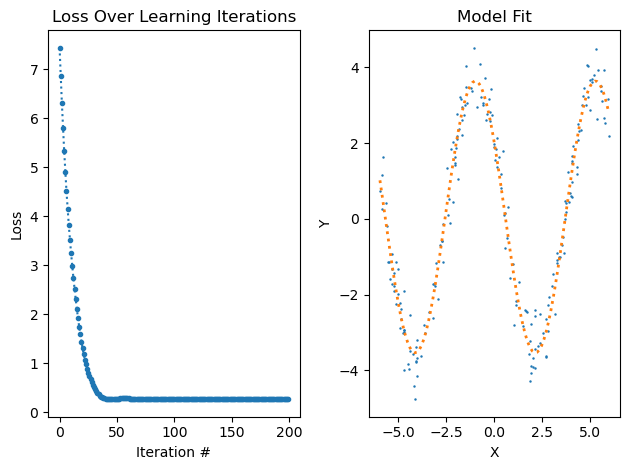

In [ ]:
# Generate Data
x = 12 * (torch.rand(200, 1) - .5)
y_obs = -3 * torch.sin(x) + 2 * torch.cos(x) + .5 * torch.randn_like(x)

# Create Model
class SinCos(nn.Module):
    def forward(self, x):
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

model = nn.Sequential(SinCos(), nn.Linear(2, 1))

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

Below is a Polynomial Expansion module, which creates 4 features!:

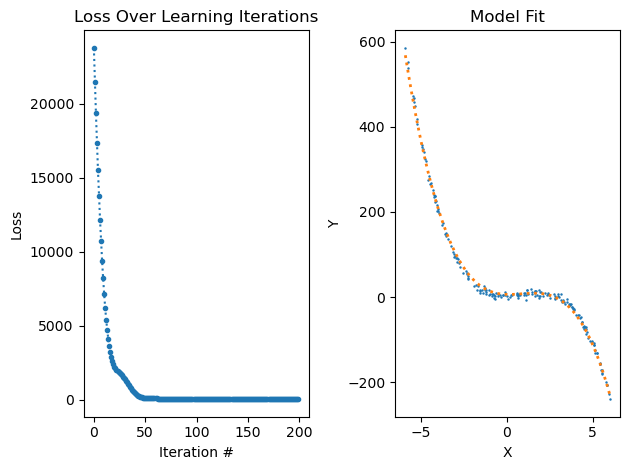

In [ ]:
# Generate Data
x = 12 * (torch.rand(200, 1) - .5)
y_obs = -2 * x ** 3 + 5 * x ** 2 + 2. * x + 2 + 5 * torch.randn_like(x)

# Create Model
class PolyFit(nn.Module):
    def forward(self, x):
        return torch.cat([x ** 0, x ** 1, x ** 2, x ** 3], dim=-1)

model = nn.Sequential(PolyFit(), nn.Linear(4, 1))

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

#### Demo: Set Parameters

It's not necessary to hard-code parameters into these modules.  By adding custom attributes to the `__init__()` method of a module, you can use the same code with multiple parameters.  In the example below, `PolyFit` can be initialized to output any specific order.

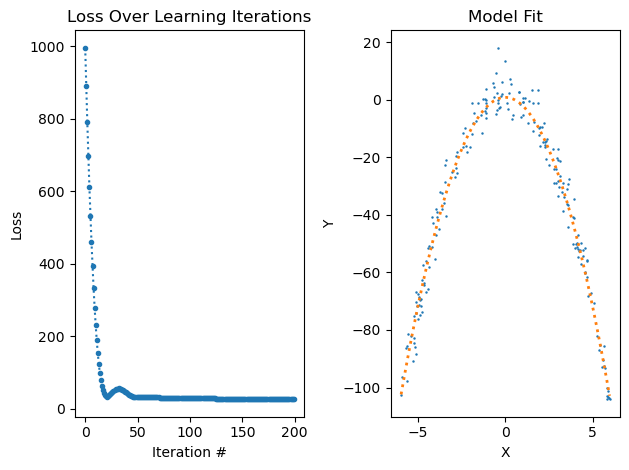

In [33]:
# Generate Data
x = 12 * (torch.rand(200, 1) - .5)
y_obs = -3 * x ** 2 + 2 + 5 * torch.randn_like(x)

# Create Model
class PolyFit(nn.Module):
    def __init__(self, order, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.order = order


    def forward(self, x):
        return x ** self.order

model = nn.Sequential(PolyFit(2), nn.Linear(1, 1))

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.1)
num_iterations = 200
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();

#### Demo: Trainable Parameters

What should the parameters be, though, to best-fit the data?  By storing the parameter in a PyTorch Tensor and wrapping it in `nn.Parameter()`, PyTorch  will automatically add the custom parameters to the training process.  

Below, a custom `weight` and `bias` parameter is added to the `Square()` module, making it self-sufficient to fit the data. You don't need to use `nn.Sequential()` or add `nn.Linear()` after `Square()` anymore.

Layer (type:depth-idx)                   Param #
Square                                   2
Total params: 2
Trainable params: 2
Non-trainable params: 0

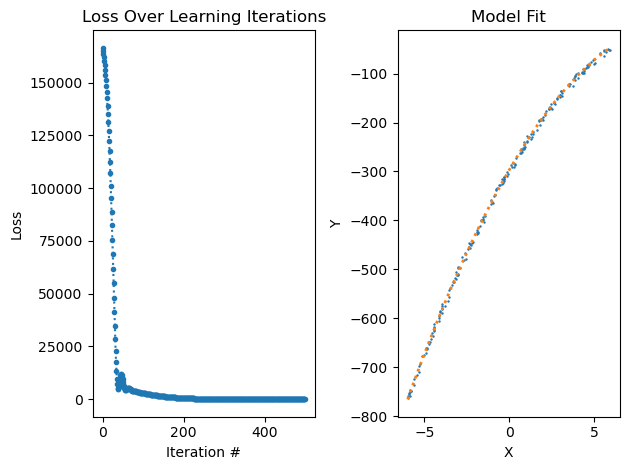

In [42]:
# Generate Data
x = 12 * (torch.rand(200, 1) - .5)
y_obs = -3 * (x - 10) ** 2 + 2 + 5 * torch.randn_like(x)

# Create Model
class Square(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.weight = nn.Parameter(torch.zeros(1, 1), )
        self.bias = nn.Parameter(torch.zeros(1, 1), )


    def forward(self, x):
        return self.weight * (x + self.bias) ** 2

model = Square()

# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=.15)
num_iterations = 500
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]

# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
summary(model)

The same is done below with the `PolyTransform` data--as the model is trained, it works out what weights to set each polynomial!

OrderedDict([('0.weight', tensor([[-2.7585e+01,  1.3809e+00, -1.8877e-03]])),
             ('0.bias', tensor([[32.3286, 32.3286, 32.3286]])),
             ('1.weight', tensor([[-2.1671]])),
             ('1.bias', tensor([-87.9808]))])

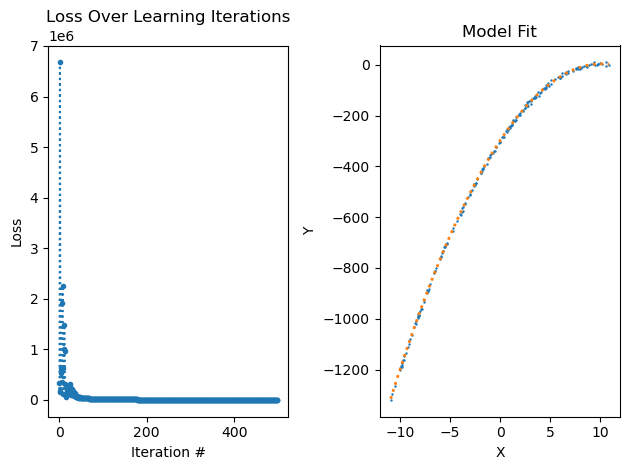

In [112]:
# Generate Data
x = 22 * (torch.rand(200, 1) - .5)
y_obs = -3 * (x - 10) ** 2 + 2 + 5 * torch.randn_like(x)

# Create Model
class PolyTransform(nn.Module):
    def __init__(self, order, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.order = order
        self.weight = nn.Parameter(torch.zeros(1, order), )
        self.bias = nn.Parameter(torch.zeros(1, order), )


    def forward(self, x):
        x_expanded = torch.cat([x ** o for o in range(1, self.order + 1)], dim=-1)
        return torch.sum(self.weight * x_expanded + self.bias, dim=-1, keepdim=True)

model = nn.Sequential(PolyTransform(order=3), nn.Linear(1, 1))

# with torch.no_grad():
#     model.weight[:] = j
# Train Model
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=2.)
num_iterations = 500
losses = [update_model(model, loss_function, optimizer, x, y_obs) for _ in range(num_iterations)]


# Plot Results
plt.subplot(1, 2, 1); plot_losses(losses);
plt.subplot(1, 2, 2); plot_1d_model_fit(model, x, y_obs);
plt.tight_layout();
summary(model)
model.state_dict()